In [1]:
import os
import datetime as dt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
def transform_johns_hopkins(df):
    df = df.groupby('Country/Region').sum()
    cols = list(df.columns)
    cols.remove('Lat')
    cols.remove('Long')
    df = df[cols]
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')
    df.index.name = "Date"
    return df#[columns]

def get_johns_hopkins(kind='confirmed'):
    assert kind in ['confirmed', 'deaths', 'recovered']
    url = f"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{kind}_global.csv"
    df = pd.read_csv(url)
    df = transform_johns_hopkins(df)
    fname = f"data/CSSEGUSandData/time_series_covid19_{kind}_global.csv"
    df.to_csv(fname)
    return df

In [3]:
def transform_sinave_eduardofv(df):
    df = df.groupby('Estado').sum()
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
    df.index.name = "Date"
    return df#[columns]

def get_sinave_eduardofv(kind="confirmados"):
    assert kind in ['confirmados', 'probables', 'muertos', 'descartados']
    url = f"https://raw.githubusercontent.com/eduardofv/covid/master/data/sinave_agregados/series_tiempo/serie_tiempo_{kind}.csv"
    df = pd.read_csv(url)
    df = transform_sinave_eduardofv(df)
    return df    

In [4]:
def get_new_per_day(df):
    new_per_day = {}
    for location in df.columns:
        d = df[location]
        dif = [d[i] - d[i-1] for i in range(1,len(d))]
        new_per_day[location] = dif

    df_new_per_day = pd.DataFrame(new_per_day)
    df_new_per_day.index = df.index[1:]
    return df_new_per_day

In [5]:
def calculate_new_last_period(df_new_per_day, PERIOD=7):
    new_per_period = {}
    for country in df_new_per_day.columns:
        d = df_new_per_day[country]
        cum = [sum(d[(i-PERIOD):i]) for i in range(PERIOD, len(d))]
        new_per_period[country] = cum
    return new_per_period

In [6]:
def cum_and_new_from_init(cum, new, init=99):
    cum_from_init = cum[cum > init]
    new_from_init = new[-len(cum_from_init):]
    assert len(cum_from_init) == len(new_from_init)
    return cum_from_init, new_from_init

def get_values_since(series, since_value, fill_to=None):
    series = series[series >= since_value]
    if fill_to is not None:
        series = pd.Series(list(series) + [0] * (fill_to - len(series)))
    return series.reset_index(drop=True)

# Mundo

In [7]:
analysis_countries = ["Mexico", "Australia", "US", "Italy", "Korea, South"]
dfw = get_johns_hopkins('confirmed')
dfw[analysis_countries].tail(10)

Country/Region,Mexico,Australia,US,Italy,"Korea, South"
Date,,,,,
2020-03-31,1094,4559,188172,105792,9786
2020-04-01,1215,4862,213372,110574,9887
2020-04-02,1378,5116,243762,115242,9976
2020-04-03,1510,5330,275586,119827,10062
2020-04-04,1688,5550,308853,124632,10156
2020-04-05,1890,5687,337072,128948,10237
2020-04-06,2143,5797,366667,132547,10284
2020-04-07,2439,5895,396223,135586,10331
2020-04-08,2785,6010,429052,139422,10384


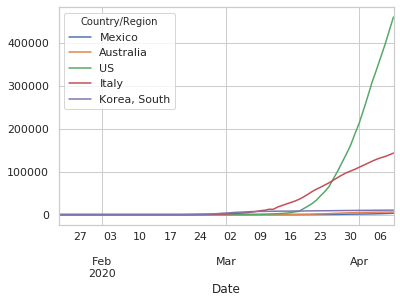

In [8]:
dfw[analysis_countries].plot(logy=False)

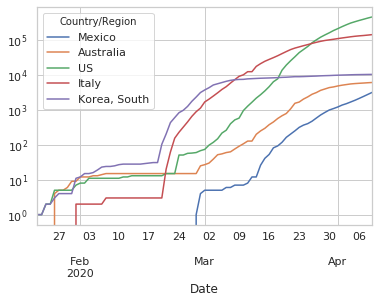

In [9]:
dfw[analysis_countries].plot(logy=True)

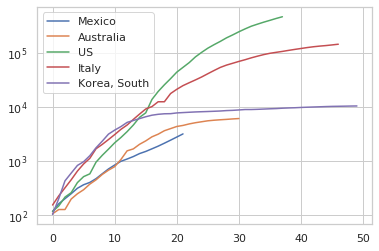

In [10]:
for country in analysis_countries:
    values_since = get_values_since(dfw[country], since_value=100)
    values_since.plot(logy=True)
plt.legend(analysis_countries)

In [11]:
dfw_new_per_day = get_new_per_day(dfw)
dfw_new_per_day[analysis_countries].tail()

,Mexico,Australia,US,Italy,"Korea, South"
Date,,,,,
2020-04-05,202,137,28219,4316,81
2020-04-06,253,110,29595,3599,47
2020-04-07,296,98,29556,3039,47
2020-04-08,346,115,32829,3836,53
2020-04-09,396,98,32385,4204,39


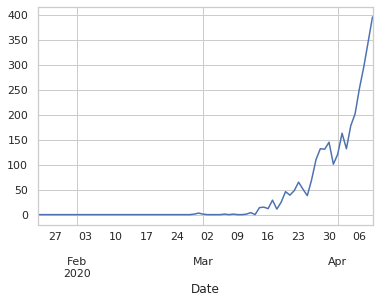

In [12]:
dfw_new_per_day['Mexico'].plot()

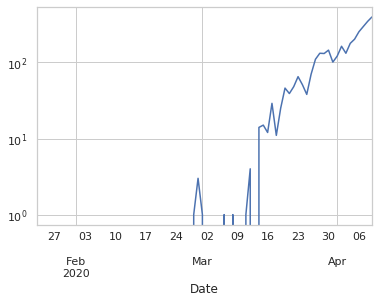

In [13]:
dfw_new_per_day['Mexico'].plot(logy=True)

Text(0, 0.5, 'new cases per day')

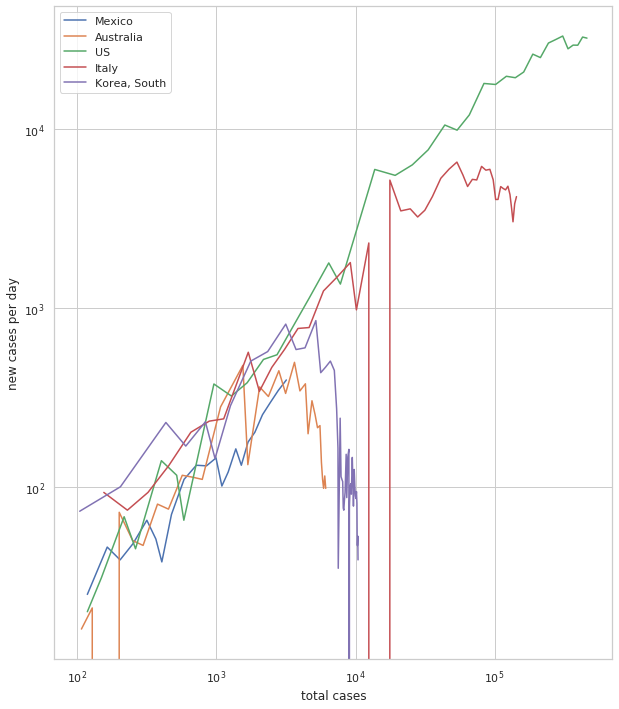

In [14]:
#Genius Eric & Aatish: https://aatishb.com/covidtrends/
f, ax = plt.subplots(figsize=[10,12])
ax.set(yscale="log", xscale="log")
for country in analysis_countries:
    cum, new = cum_and_new_from_init(dfw[country], 
                                     dfw_new_per_day[country], 
                                     init=100)
    plt.plot(cum, new)
plt.legend(analysis_countries)
plt.xlabel("total cases")
plt.ylabel("new cases per day")

Text(0, 0.5, 'new cases last days')

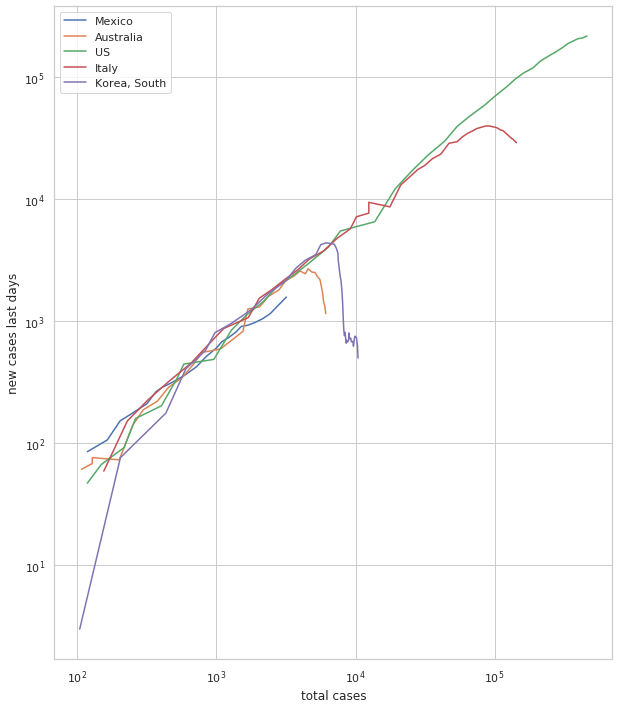

In [15]:
new_last_period = calculate_new_last_period(dfw_new_per_day, PERIOD=7)

#Genius Eric & Aatish: https://aatishb.com/covidtrends/
f, ax = plt.subplots(figsize=[10,12])
ax.set(yscale="log", xscale="log")
for country in analysis_countries:
    cum, new = cum_and_new_from_init(dfw[country], 
                                     new_last_period[country], 
                                     init=100)
    plt.plot(cum, new)
plt.legend(analysis_countries)
plt.xlabel("total cases")
plt.ylabel("new cases last days")

# México

In [16]:
estados = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]

dfmx = get_sinave_eduardofv('confirmados')
dfmx_descartados = get_sinave_eduardofv('descartados')
dfmx_probables = get_sinave_eduardofv('probables')
dfmx[estados].tail(10)

Estado,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-03-31,234,76,94,29
2020-04-01,296,78,99,29
2020-04-02,327,84,104,32
2020-04-03,384,85,116,35
2020-04-04,469,88,120,36
2020-04-05,560,91,123,38
2020-04-06,609,93,126,40
2020-04-07,723,93,135,45
2020-04-08,855,98,139,47


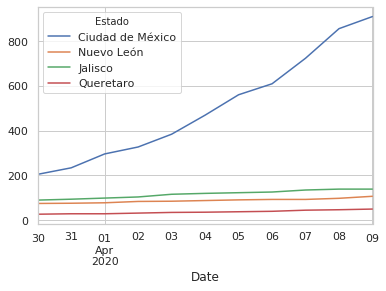

In [17]:
dfmx[estados].plot(logy=False)

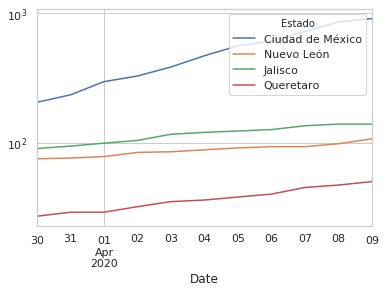

In [18]:
dfmx[estados].plot(logy=True)

In [19]:
total_mx = dfmx.sum(axis=1)
total_mx[-10:]

Date
2020-03-31    1215
2020-04-01    1378
2020-04-02    1510
2020-04-03    1688
2020-04-04    1890
2020-04-05    2143
2020-04-06    2439
2020-04-07    2785
2020-04-08    3181
2020-04-09    3441
dtype: int64

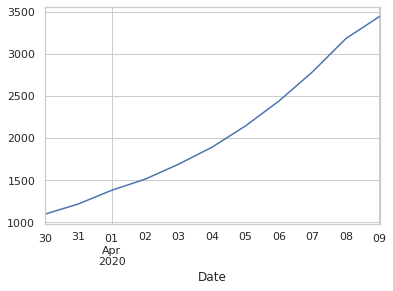

In [20]:
total_mx.plot()

In [21]:
dfmx_new_per_day = get_new_per_day(dfmx)
dfmx_new_per_day[estados].tail()

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-05,91,3,3,2
2020-04-06,49,2,3,2
2020-04-07,114,0,9,5
2020-04-08,132,5,4,2
2020-04-09,54,9,0,3


In [22]:
total_new = dfmx_new_per_day.sum(axis=1)
total_new[-10:]

Date
2020-03-31    121
2020-04-01    163
2020-04-02    132
2020-04-03    178
2020-04-04    202
2020-04-05    253
2020-04-06    296
2020-04-07    346
2020-04-08    396
2020-04-09    260
dtype: int64

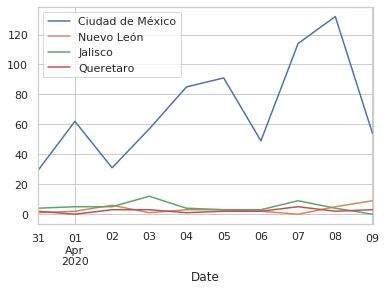

In [23]:
for estado in estados:
    dfmx_new_per_day[estado].plot()
plt.legend(estados)

In [24]:
total_probables = dfmx_probables.sum(axis=1)
total_descartados = dfmx_descartados.sum(axis=1)
total_pruebas = total_mx + total_probables + total_descartados
prop_confirmados = total_mx / total_pruebas
prop_confirmados[-10:]

Date
2020-03-31    0.110374
2020-04-01    0.112233
2020-04-02    0.107973
2020-04-03    0.107612
2020-04-04    0.109986
2020-04-05    0.118831
2020-04-06    0.119121
2020-04-07    0.109603
2020-04-08    0.107546
2020-04-09    0.109252
dtype: float64

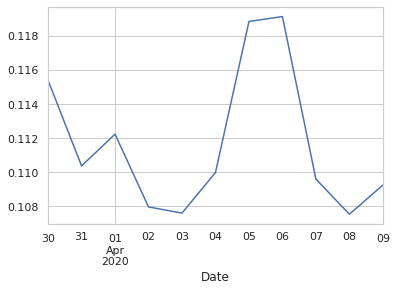

In [25]:
prop_confirmados.plot()